In [1]:
import os
import datetime
import numpy as np
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from explore.datasets.utils import cost_computation, load_trees, compute_hausdorff

dataset_paths = "../multirun/2026-02-26/11-38-56"
ds_c = len(os.listdir(dataset_paths))-1

## Cost evolution over nodes

../multirun/2026-02-26/11-38-56/0
16
Looking at start_idx 1 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1392  RRT nodes.


1367it [00:00, 7352.08it/s]


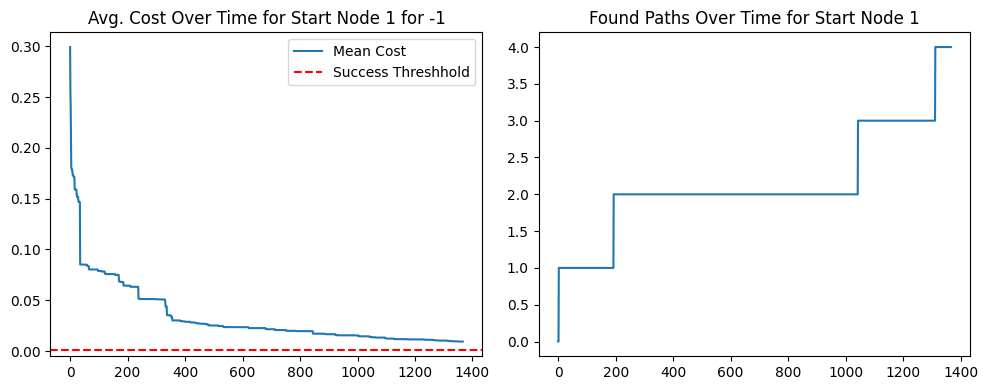

../multirun/2026-02-26/11-38-56/1
16
Looking at start_idx 2 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1395  RRT nodes.


1370it [00:00, 7119.04it/s]


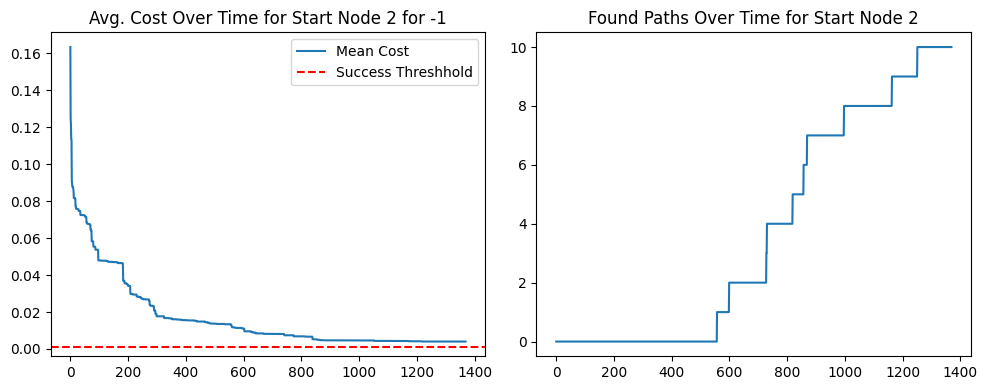

../multirun/2026-02-26/11-38-56/2
16
Looking at start_idx 3 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1507  RRT nodes.


1482it [00:00, 7104.08it/s]


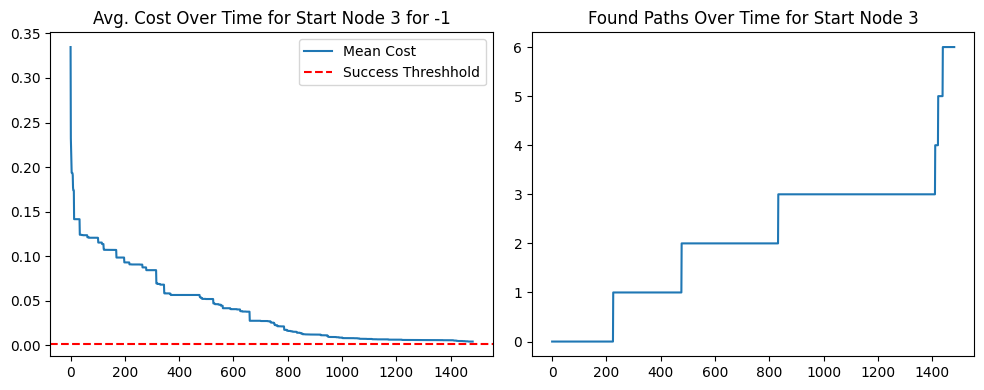

../multirun/2026-02-26/11-38-56/3
16
Looking at start_idx 4 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1449  RRT nodes.


1424it [00:00, 6819.12it/s]


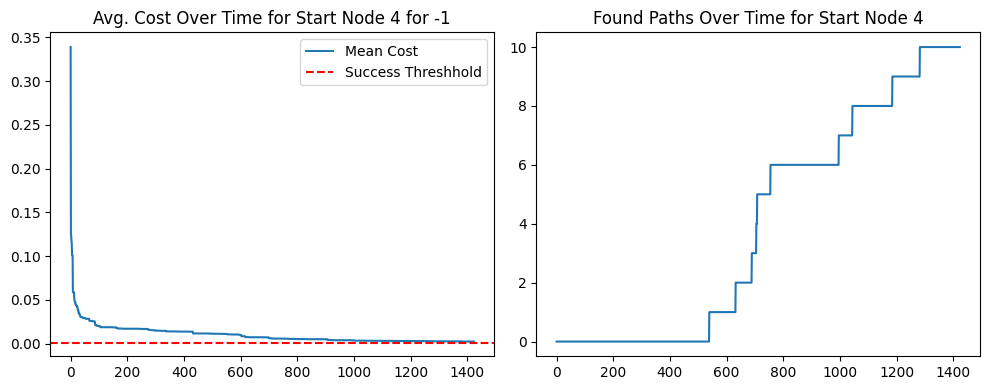

../multirun/2026-02-26/11-38-56/4
16
Looking at start_idx 5 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1415  RRT nodes.


1390it [00:00, 7421.84it/s]


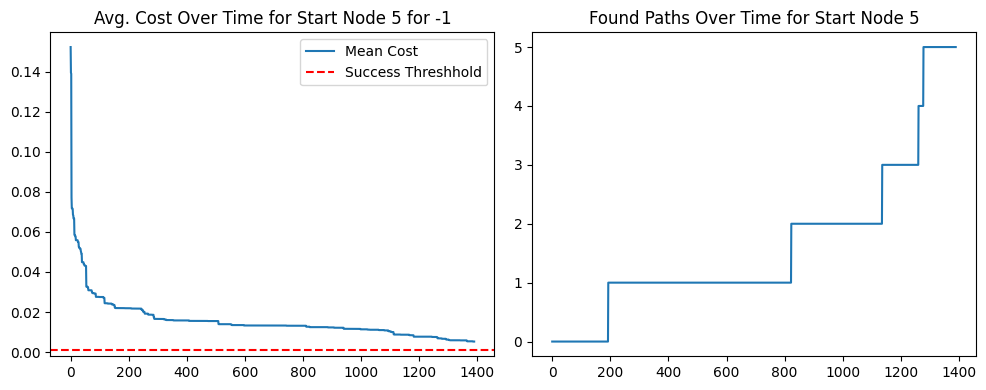

../multirun/2026-02-26/11-38-56/5
16
Looking at start_idx 6 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1411  RRT nodes.


1386it [00:00, 6478.22it/s]


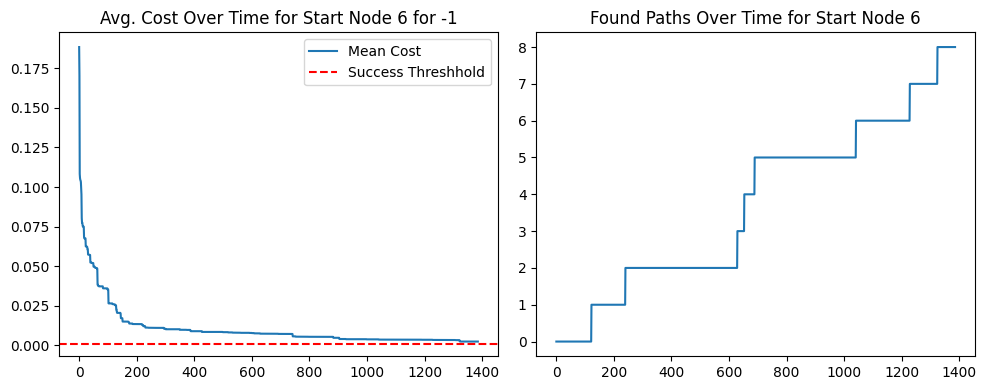

../multirun/2026-02-26/11-38-56/6
16
Looking at start_idx 7 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1391  RRT nodes.


1366it [00:00, 6982.82it/s]


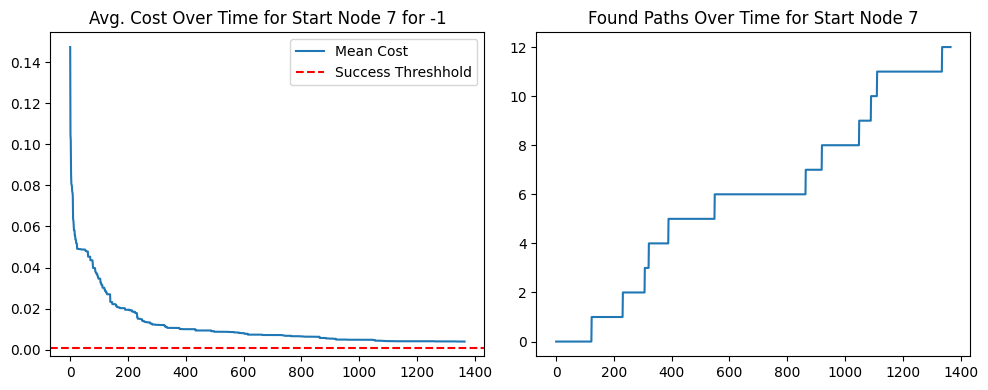

../multirun/2026-02-26/11-38-56/7
16
Looking at start_idx 8 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1404  RRT nodes.


1379it [00:00, 7087.54it/s]


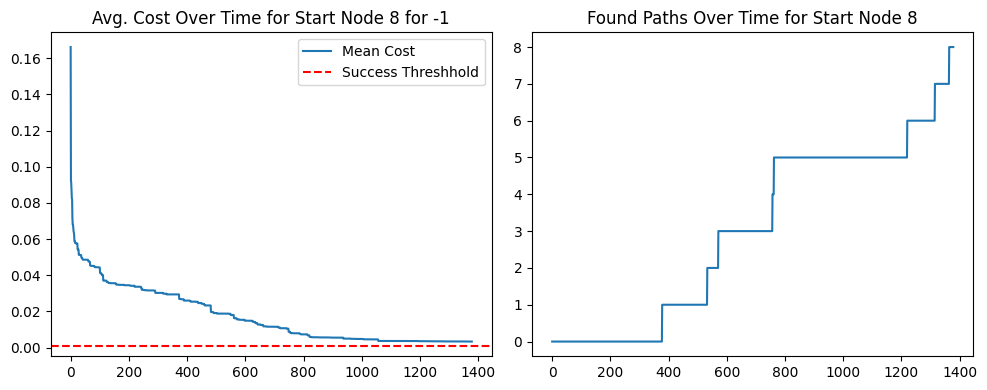

../multirun/2026-02-26/11-38-56/8
16
Looking at start_idx 9 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1417  RRT nodes.


1392it [00:00, 7071.41it/s]


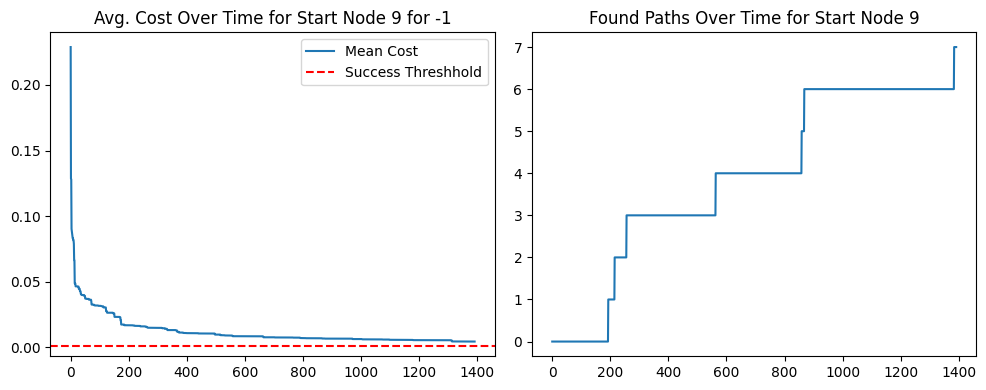

../multirun/2026-02-26/11-38-56/9
16
Looking at start_idx 10 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005
Tree Count: 26
Loaded  1287  RRT nodes.


1262it [00:00, 7058.74it/s]


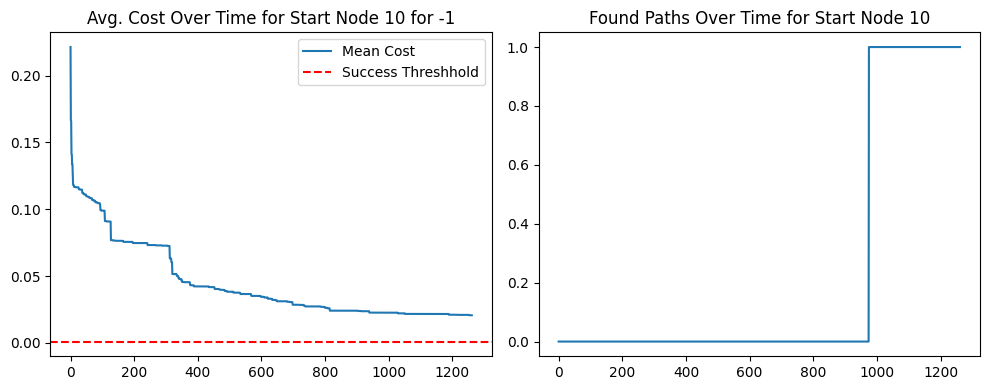

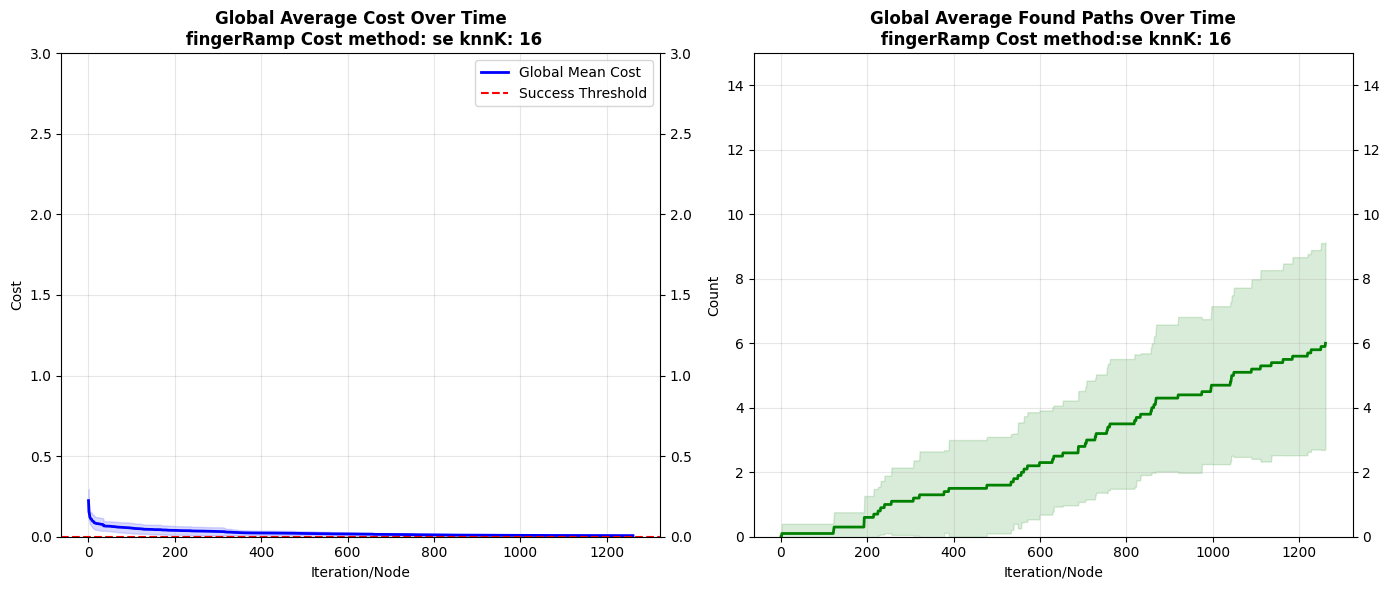

Global Average Final Successes for cost se: 6.00
Best Experiment Folder: ../multirun/2026-02-26/11-38-56/6 (12 paths)


100%|██████████| 26/26 [00:00<00:00, 28826.83it/s]

AVG hausdorff for paths between config 10 and 16:  0.024292258040578767
2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
best_found_paths_count = 0
best_folder_name = ""

all_mean_costs = []
all_found_paths = []
all_hausdorffs = []

for folder_name in range(ds_c):
    
    dataset = f"{dataset_paths}/{folder_name}"

    print(dataset)

    config_path = os.path.join(dataset, ".hydra/config.yaml")
    cfg = OmegaConf.load(config_path)
    knnK = cfg.RRT.knnK
    print(knnK)

    ERROR_THRESH = cfg.RRT.min_cost
    path_diff_thresh = cfg.RRT.path_diff_thresh
    cost_max_method = False

    look_at_specific_start_idx = cfg.RRT.start_idx
    look_at_specific_end_idx = cfg.RRT.end_idx
    cfg.RRT.start_idx = 0
    look_at_specific_end_idx = -1
    # cutoff = 2500
    cutoff = -1

    q_mask = np.array(cfg.RRT.q_mask)
    sim_cfg = cfg.RRT.sim

    mujoco_xml = os.path.join("..", sim_cfg.mujoco_xml)

    print(f"Looking at start_idx {look_at_specific_start_idx} and end_idx {look_at_specific_end_idx} with error threshold {ERROR_THRESH}.")
    print(f"Tau action: {cfg.RRT.sim.tau_action}; Tau sim: {cfg.RRT.sim.tau_sim}")

    tree_dataset = os.path.join(dataset, "trees")
    trees, tree_count, total_nodes_count = load_trees(tree_dataset, cutoff, verbose=1)

    if not q_mask.shape[0]:
        q_mask = np.ones_like(trees[0][0]["state"][1])

    print("Loaded ", total_nodes_count, " RRT nodes.")

    # time_taken = float(np.loadtxt(os.path.join(dataset, "time_taken.txt")))
    # print(f"Time taken to generate tree: {datetime.timedelta(seconds=time_taken)}")

    si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

    costs_over_time = []
    for i, node in tqdm(enumerate(trees[si])):

        costs = []
        
        for target_idx in range(tree_count):
            # TODO: Cost computation should maybe be the same for all in this case?
            cost = cost_computation(trees[target_idx][0], node, q_mask, cost_max_method)
            if i == 0 or costs_over_time[i-1][target_idx] > cost:
                costs.append(cost)
            else:
                costs.append(costs_over_time[i-1][target_idx])

        costs_over_time.append(costs)

    # Subtract 1 because it also contains a cost against itself
    mean_cost_over_time = [sum(costs)/(len(costs)-1) for costs in costs_over_time]
    found_paths_over_time = [len([1 for c in costs if c < ERROR_THRESH])-1 for costs in costs_over_time]

    all_mean_costs.append(mean_cost_over_time)
    all_found_paths.append(found_paths_over_time)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].set_title(f"Avg. Cost Over Time for Start Node {si} for {cfg.RRT.max_configs}")
    axes[0].plot(mean_cost_over_time, label="Mean Cost")

    if cfg.RRT.end_idx != -1:
        cost_for_target_over_time = [costs[cfg.RRT.end_idx] for costs in costs_over_time]
        axes[0].plot(cost_for_target_over_time, label=f"Target {cfg.RRT.end_idx}")

    axes[0].axhline(y=ERROR_THRESH, color="red", linestyle="--", label="Success Threshhold")
    axes[0].legend()

    axes[1].set_title(f"Found Paths Over Time for Start Node {si}")
    axes[1].plot(found_paths_over_time)

    if best_found_paths_count < found_paths_over_time[-1]:
        best_found_paths_count = found_paths_over_time[-1]
        best_folder_name = dataset

    plt.tight_layout()
    plt.show()

    hd =  compute_hausdorff(trees, tree_count, q_mask, cost_max_method, ERROR_THRESH)
    print("Hausdorff:", hd)
    all_hausdorffs.append(hd)

# --- Calculate means and standard deviations ---
min_len = min(len(x) for x in all_mean_costs)
all_mean_costs_trimmed = np.array([x[:min_len] for x in all_mean_costs])
all_found_paths_trimmed = np.array([x[:min_len] for x in all_found_paths])

avg_cost = np.mean(all_mean_costs_trimmed, axis=0)
std_cost = np.std(all_mean_costs_trimmed, axis=0)
avg_paths = np.mean(all_found_paths_trimmed, axis=0)
std_paths = np.std(all_found_paths_trimmed, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Slightly wider for better labels

# --- Plot 1: Average Cost ---
axes[0].set_title(f"Global Average Cost Over Time\n fingerRamp Cost method: {cfg.RRT.cost_method} knnK: {cfg.RRT.knnK}", fontweight='bold')
axes[0].plot(avg_cost, label="Global Mean Cost", color='blue', linewidth=2)
axes[0].fill_between(range(min_len), avg_cost - std_cost, avg_cost + std_cost, alpha=0.15, color='blue')
axes[0].axhline(y=ERROR_THRESH, color="red", linestyle="--", label="Success Threshold")

axes[0].set_xlabel("Iteration/Node")
axes[0].set_ylabel("Cost")
axes[0].grid(True, alpha=0.3)

# Add ticks to the right side
axes[0].tick_params(axis='y', which='both', right=True, labelright=True)
axes[0].legend(loc='upper right')

# --- Plot 2: Average Found Paths ---
axes[1].set_title(f"Global Average Found Paths Over Time\n fingerRamp Cost method:{cfg.RRT.cost_method} knnK: {cfg.RRT.knnK}", fontweight='bold')
axes[1].plot(avg_paths, color='green', linewidth=2)
axes[1].fill_between(range(min_len), avg_paths - std_paths, avg_paths + std_paths, alpha=0.15, color='green')

axes[1].set_xlabel("Iteration/Node")
axes[1].set_ylabel("Count")
axes[1].grid(True, alpha=0.3)

# Add ticks to the right side
axes[1].tick_params(axis='y', which='both', right=True, labelright=True)


axes[0].set_ylim(0, 3)   # or hard-code numbers

max_possible_paths = 15
axes[1].set_ylim(0, max_possible_paths)

plt.tight_layout()
plt.show()

print(f"Global Average Final Successes for cost {cfg.RRT.cost_method}: {avg_paths[-1]:.2f}")
print(f"Best Experiment Folder: {best_folder_name} ({best_found_paths_count} paths)")
print(f"Global Average Hausdorff: {np.mean(np.array(all_hausdorffs))}")



In [8]:
if best_found_paths_count == 0:
    print("No parameters lead to paths being found!")
else:
    print(f"Best results achieved with '{best_folder_name}'! ({best_found_paths_count} of {tree_count} paths found)")

Best results achieved with '../outputs/2026-02-17/14-20-24'! (21 of 100 paths found)
